### Bibliotecas

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import os

### Importando Datos

In [2]:
path = '/home/faber/EK_AutoNOMOS_Sim/src/autonomos_gazebo_simulation/scripts'
passingDir = path + '/dataTRAIN'
passingImagesDir = passingDir + '/dataset_passing'
#passingImages = !ls -1 '{passingImagesDir}'
passingImages = os.listdir(passingImagesDir)

print('Imágenes de ciudad: ', len(passingImages))

Imágenes de ciudad:  16836


In [3]:
lidarCSV = passingDir + '/lidar.csv'
outputsCSV = passingDir + '/outputs.csv'

outputs = pd.read_csv(outputsCSV, names=['angle', 'speed'], sep='\t')
lidar = pd.read_csv(lidarCSV, sep='\t', header=None)
lidar = lidar.iloc[: , :-1]

print("Diferencia entre tamaño de los DF y numero de imgs: ")
print((len(outputs) - len(passingImages)))
print((len(lidar) - len(passingImages)))

data = pd.concat([outputs, lidar], axis=1, join='inner')
data['img'] = sorted(passingImages, key=lambda x:int(x.replace('_camara.png', '')))

cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]

Diferencia entre tamaño de los DF y numero de imgs: 
0
0


In [4]:
#lidar.head()
#outputs.head()
data.head()

,img,angle,speed,0,1,2,3,4,5,6,...,350,351,352,353,354,355,356,357,358,359
0,1_camara.png,103.0,-600,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,2_camara.png,103.0,-600,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
2,3_camara.png,103.0,-600,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
3,4_camara.png,106.0,-600,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
4,5_camara.png,106.0,-600,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


### Visualizando datos y binning

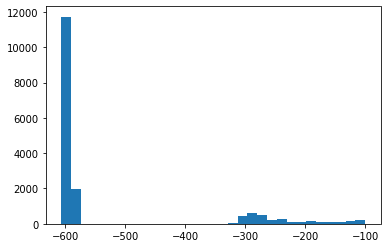

In [5]:
plt.hist(data['speed'], bins = 31)
plt.show()

In [6]:
def binningData(nbins, samplesPerBin, data):
  hist, bins = np.histogram(data['speed'].to_numpy(), nbins)
  removeIndexList = []
  for j in range(nbins):
    binDataList = []
    for i in range(len(data['speed'])):
      if data['speed'][i] >= bins[j] and data['speed'][i] <= bins[j+1]:
        binDataList.append(i)
    binDataList = shuffle(binDataList)
    binDataList = binDataList[samplesPerBin:]
    removeIndexList.extend(binDataList)
  print('Removed images: ', len(removeIndexList))
  data.drop(data.index[removeIndexList], inplace=True)
  print('Remaining images: ', len(data))

In [7]:
#binningData(31, 1000, data)
data = data[data['speed'] <= -500]

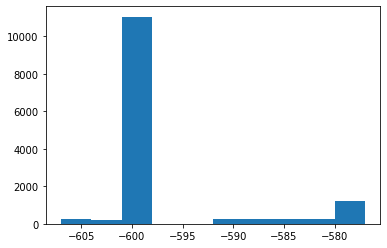

In [8]:
plt.hist(data['speed'])
plt.show()

### Input pipeline

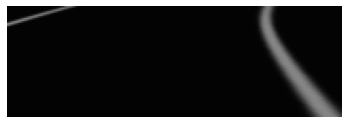

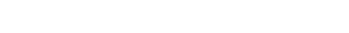

out:  (-0.0888888888888889, 0.75)
(66, 200, 3)
(20, 360, 3)


In [9]:
def crop(inimg):
  #image = inimg[270:405, :, :]
  image = inimg[270:405, :, :]
  #image = inimg[220:370, :, :]
  image = tf.image.resize(image, [66, 200])
  #image = tf.image.rgb_to_yuv(image) # Lo he probado con YUV, pero no he visto mejoras perceptibles
  return image

def normalize(image):
  #inImg = (image/127.5) - 1  # normaliza de 0 a 255 -> -1 a 1
  inImg = image/255           # normaliza de 0 a 255 -> 0 a 1
  return inImg

def loadPista(filename, angle, speed, lidar, dir, flip = False, augment = False):
  inImg = tf.cast(tf.image.decode_jpeg(tf.io.read_file(dir + '/' + filename)), tf.float32)[...,:3]
  #inImg = tf.image.adjust_contrast(inImg, 2)
  #inImg = tf.image.adjust_brightness(inImg, delta = 0.1) # udacity simulaton
  angle = ((angle/180)*2)-1
  # aumentación de datos aleatoria
  if augment:
    if np.random.rand() < 0.5:
      inImg = tf.image.random_hue(inImg, .2)
    if np.random.rand() < 0.5:
      inImg = tf.image.random_saturation(inImg, 1, 3)
    if np.random.rand() < 0.5:
      inImg = tf.image.random_brightness(inImg, 0.5)
    if np.random.rand() < 0.5:
      inImg = tf.image.random_contrast(inImg, 0.4, 1)

  inImg = normalize(inImg)
  inImg = crop(inImg)
  
  # se invierte la imágen horizontalmente y si se hace, se invirte el ángulo
  if flip:
    inImg = tf.image.flip_left_right(inImg)
    angle = angle * -1
    lidar = lidar[::-1]

  # el último paso de la aumentación de datos es un corte aleatorio al que después
  # se le cambia el tamaño para que pueda ser procesado por la red
  if augment:
    if np.random.rand() < 0.5:
      inImg = tf.image.random_crop(value=inImg, size=(50, 150, 3))
      #inImg = tf.image.resize(inImg, [66, 200])
      inImg = tf.image.resize(inImg, [66, 200])

  
  speed = -speed/800
  outputs = (angle, speed)

  # lidar as img
  lidar = lidar[::-1]
  #lidar.astype('float32')
  lidar = tf.roll(lidar, 180, axis = 0)
  lidar /= 3
  lidarImg = [
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              lidar,
              ]
  lidarImg = [lidarImg,lidarImg,lidarImg]
  
  lidarImg = tf.transpose(lidarImg,[1, 2, 0])
  #inImg = tf.concat([inImg, lidarImg], 0)
  inImg = (inImg, lidarImg)

  return inImg, outputs

# Prueba función de load
row = data.iloc[3980] #de 3900 a 4030 hay un rebase después del binning a 800 en speed en el primer dataset
lidarVector = row[3:363].to_numpy().astype('float32')
image, angle = loadPista(row['img'], row['angle'], row['speed'], lidarVector, passingImagesDir, flip=False, augment=True)
#plt.title('Imagen de prueba: ' + urlsPista2_manual[0])
#plt.imshow((image + 1) / 2)    # Si se normalizó de -1 a 1
plt.imshow(image[0])               # Si se normalizó de 0 a 1
plt.axis('off')
plt.show()
plt.imshow(image[1])               # Si se normalizó de 0 a 1
plt.axis('off')
plt.show()
print('out: ', angle)
print(image[0].shape)
print(image[1].shape)
#plt.imshow(tf.cast(tf.image.decode_jpeg(tf.io.read_file(passingImagesDir + '/' + row['img'])), tf.uint8)[...,:3])
#print(np.shape(image))

In [20]:
cols = data.columns.tolist()
cols = cols[3:363]

dataset_p1 = tf.data.Dataset.from_tensor_slices((
    data['img'].to_list(), 
    np.squeeze(data['angle'].to_numpy()), 
    np.squeeze(data['speed'].to_numpy()), 
    np.squeeze(data[cols].to_numpy().astype('float32'))
    ))
dataset_p1 = dataset_p1.map(lambda img, ang, spd, radar: loadPista(img, ang, spd, radar, passingImagesDir, flip=False, augment=False))

dataset_p2 = tf.data.Dataset.from_tensor_slices((
    data['img'].to_list(), 
    np.squeeze(data['angle'].to_numpy()), 
    np.squeeze(data['speed'].to_numpy()), 
    np.squeeze(data[cols].to_numpy().astype('float32'))
    ))
dataset_p2 = dataset_p2.map(lambda img, ang, spd, radar: loadPista(img, ang, spd, radar, passingImagesDir, flip=False, augment=True))

dataset_p3 = tf.data.Dataset.from_tensor_slices((
    data['img'].to_list(), 
    np.squeeze(data['angle'].to_numpy()), 
    np.squeeze(data['speed'].to_numpy()), 
    np.squeeze(data[cols].to_numpy().astype('float32'))
    ))
dataset_p3 = dataset_p3.map(lambda img, ang, spd, radar: loadPista(img, ang, spd, radar, passingImagesDir, flip=True, augment=True))

dataset_p4 = tf.data.Dataset.from_tensor_slices((
    data['img'].to_list(), 
    np.squeeze(data['angle'].to_numpy()), 
    np.squeeze(data['speed'].to_numpy()), 
    np.squeeze(data[cols].to_numpy().astype('float32'))
    ))
dataset_p4 = dataset_p4.map(lambda img, ang, spd, radar: loadPista(img, ang, spd, radar, passingImagesDir, flip=False, augment=True))

fullDataset = dataset_p2
#fullDataset = dataset_p1.concatenate(dataset_p2)
#fullDataset = fullDataset.concatenate(dataset_p3)
#fullDataset = fullDataset.concatenate(dataset_p4)
fullDataset = fullDataset.batch(8)
DATASET_SIZE = fullDataset.cardinality().numpy()
#fullDataset = fullDataset.shuffle(DATASET_SIZE)

train_size = int(1 * DATASET_SIZE)
val_size = int(0 * DATASET_SIZE)

print("Tamaño del dataset en lotes (batches): ", DATASET_SIZE)
print("Tamaño del dataset de entrenamiento en lotes (batches): ", train_size)
print("Tamaño del dataset de validacipon en lotes (batches): ", val_size)

train_dataset = fullDataset.take(train_size)
val_dataset = fullDataset.skip(train_size)

Tamaño del dataset en lotes (batches):  1713
Tamaño del dataset de entrenamiento en lotes (batches):  1713
Tamaño del dataset de validacipon en lotes (batches):  0


### RED 1 (OSCAR)

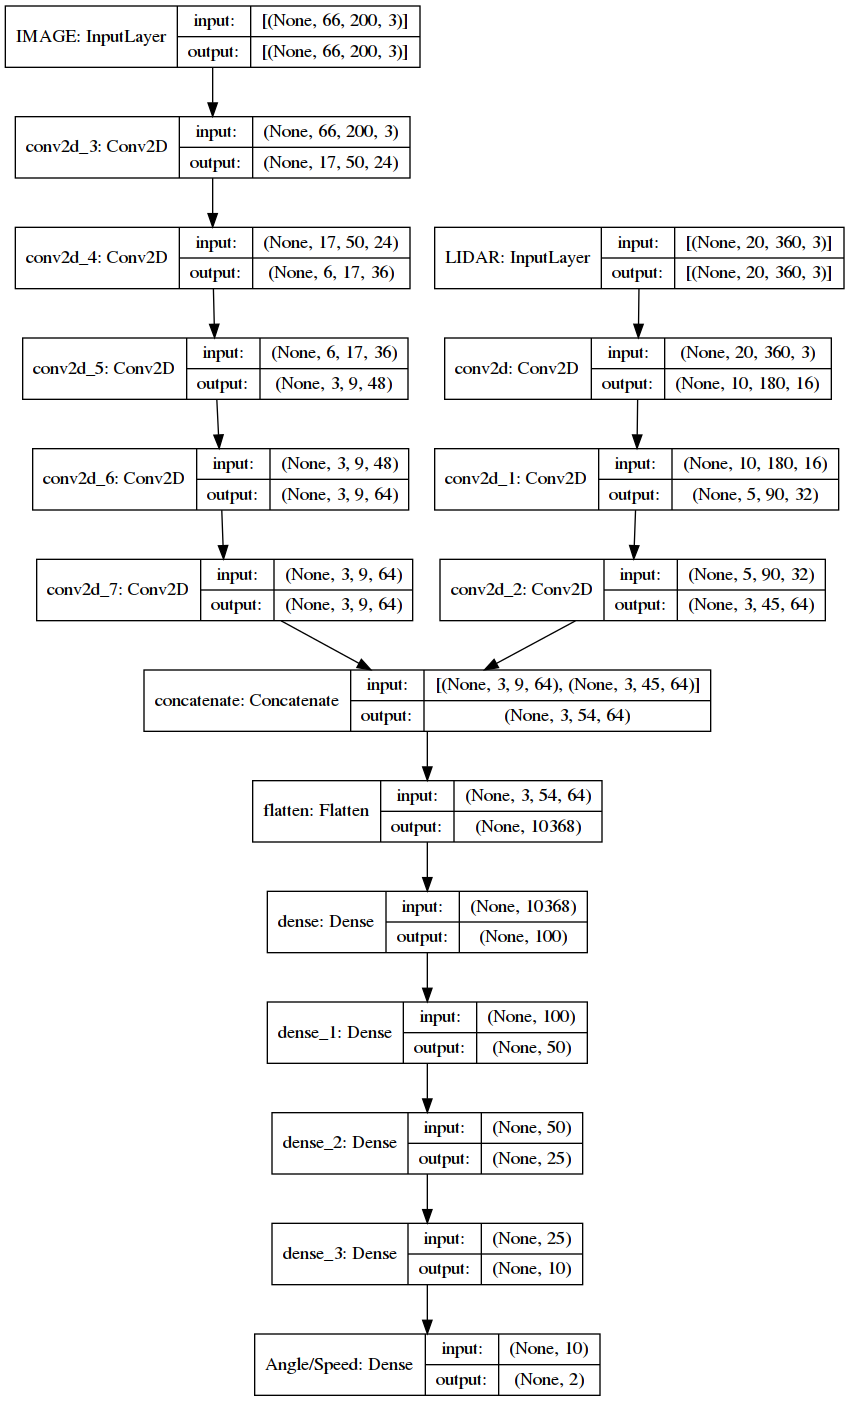

In [12]:
""" # Red
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

initializer = tf.random_normal_initializer(0., 0.04)

cam = keras.Input(shape=([66,200,3]), name="IMAGE")
lidar = keras.Input(shape=([20,360,3]), name="LIDAR")

convLidarLayer0 = layers.Conv2D(16, (5, 5), (2,2) , activation='elu',padding='SAME', kernel_initializer = initializer)(lidar)
convLidarLayer1 = layers.Conv2D(32, (3, 3), (2,2) , activation='elu',padding='SAME', kernel_initializer = initializer)(convLidarLayer0)
convLidarLayer2 = layers.Conv2D(64, (3, 3), (2,2) , activation='elu',padding='SAME', kernel_initializer = initializer)(convLidarLayer1)

convCamConvLayer0 = layers.Conv2D(24, (5, 5), (4,4), activation='elu',padding='SAME', kernel_initializer = initializer)(cam)
convCamConvLayer1 = layers.Conv2D(36, (5, 5), (3,3), activation='elu', padding='SAME', kernel_initializer = initializer)(convCamConvLayer0)
convCamConvLayer2 = layers.Conv2D(48, (5, 5), (2,2), activation='elu', padding='SAME', kernel_initializer = initializer)(convCamConvLayer1)
convCamConvLayer3 = layers.Conv2D(64, (5, 5), (1,1), activation='elu', padding='SAME', kernel_initializer = initializer)(convCamConvLayer2)
convCamConvLayer4 = layers.Conv2D(64, (3, 3), (1,1), activation='elu', padding='SAME', kernel_initializer = initializer)(convCamConvLayer3)

concat = layers.concatenate([convCamConvLayer4, convLidarLayer2], axis = 2)
#reduce = 
rushia = layers.Flatten()(concat)

denseLayer0 = layers.Dense(100, activation='elu')(rushia)
denseLayer1 = layers.Dense(50, activation='elu')(denseLayer0)
denseLayer2 = layers.Dense(25, activation='elu')(denseLayer1)
denseLayer3 = layers.Dense(10, activation='elu')(denseLayer2)

# Outputs
dirVel = layers.Dense(2, name="Angle/Speed")(denseLayer3)

#opt = tf.keras.optimizers.Adam(learning_rate=0.3)
opt = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

model = keras.Model(
    inputs = [cam, lidar],
    outputs = [dirVel]
)


model.compile(
    loss='mean_absolute_error',
    #loss = 'mean_squared_error',
    metrics = 'mean_absolute_error',
    optimizer= opt
    )

#print(model.summary())
keras.utils.plot_model(model, show_shapes = True) """

In [21]:
model = tf.keras.models.load_model('models/RevaseV0.h5')
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
IMAGE (InputLayer)              [(None, 66, 200, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 17, 50, 24)   1824        IMAGE[0][0]                      
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 6, 17, 36)    21636       conv2d_3[0][0]                   
__________________________________________________________________________________________________
LIDAR (InputLayer)              [(None, 20, 360, 3)] 0                                            
______________________________________________________________________________________________

### Train

In [24]:
for layer in model.layers:
    layer.trainable = True
    #print(layer.trainable)
    """ if "conv" in layer.name:
        print('-------------')
        layer.trainable = False
        print(layer.name)
        print(layer.trainable) """

In [22]:
history = model.fit(
    train_dataset,
    epochs =1,
    #validation_data = val_dataset
    )

1713/1713 [==============================] - 190s 110ms/step - loss: 0.0460 - mean_absolute_error: 0.0460


In [13]:
#import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(path + '/models/RevaseV1.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpbazm3pfc/assets


INFO:tensorflow:Assets written to: /tmp/tmpbazm3pfc/assets


In [23]:
# Guarda el modelo
model.save(path +'/models/RevaseV1.h5')

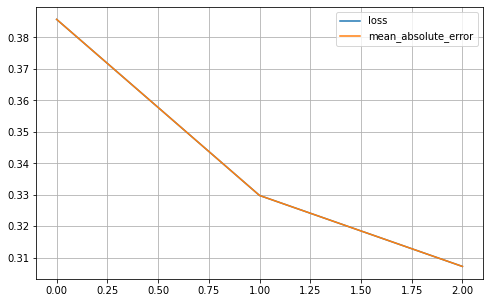

In [14]:
pd.DataFrame(history.history).plot(figsize = (8, 5))
plt.grid(True)
#plt.ylim((0,1))
plt.show()

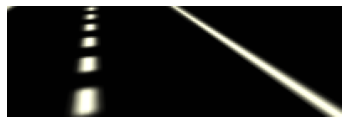

predict:  0.07361676 -0.0035497993
Truth:  [0.24444444 0.98888889 0.33333333 0.25555556 0.27777778 0.2
 0.12222222 0.07777778] [1. 1. 1. 1. 1. 1. 1. 1.]


In [36]:
for testImage, angle in train_dataset.take(10):
  pass

predict = model(testImage, training = False)

#plt.imshow((testImage[0, ...] + 1) / 2)   # Si se normalizó de -1 a 1
plt.imshow(testImage[0][0, ...])              # Si se normalizó de 0 a 1
plt.axis('off')
plt.show()
print('predict: ', predict.numpy()[0][0], predict.numpy()[0][1])
print('Truth: ', angle[0].numpy(), angle[1].numpy())